In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob
import xgboost

In [59]:
##BEFORE YOU GO FURTHER WITH THIS: the geemap function zonal_stats may not be appropriate for the task you used it for!

##Potential solution: create 3x3 array with point as center, then zonal average??

##Proof of concept
os.chdir(r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/')
df = pd.read_csv('GA_spectra_FINAL_3-4-22.csv') ##very different results than GA_spectra

##Variables from Byrd et al. 2018:
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

display(df)

for col in df.columns:
    print(col)

# g = sns.scatterplot(x = 'NIR_band', y = 'Mean_Biomass', data = df)
# plt.show()

,2000_B1,2000_B2,2000_B3,2000_B4,2000_B5,2000_B6,2000_B7,2001_B1,2001_B2,2001_B3,...,Red_band,NIR_band,SWIR1_band,SWIR2_band,savi,wdrvi5,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r
0,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0347,0.0641,0.0540,0.0333,0.073647,-0.039700,-0.001439,0.085803,-0.316222,-0.020588
1,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0389,0.0788,0.0844,0.0532,0.096892,0.006386,-0.073810,0.223881,-0.193939,0.155266
2,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0374,0.0895,0.0748,0.0410,0.124661,0.089470,-0.007958,0.084165,-0.371648,0.045918
3,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0321,0.1092,0.0647,0.0350,0.180337,0.259516,0.011024,0.084629,-0.514563,0.043219
4,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0610,0.1242,0.1149,0.0655,0.138354,0.008936,-0.048362,0.038640,-0.309436,0.035573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,0.0549,0.1367,0.1094,0.0613,0.177415,0.109128,-0.047702,0.134272,-0.380808,0.055077
204,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,0.0368,0.0932,0.0731,0.0405,0.134286,0.117506,-0.055199,0.116848,-0.394166,0.047865
205,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,0.0346,0.0834,0.0555,0.0303,0.118447,0.093054,-0.052055,0.131075,-0.467018,-0.066256
206,0.0361,0.0487,0.0495,0.1084,0.1146,0.2920,0.0592,0.0306,0.0401,0.0425,...,0.0475,0.0905,0.0928,0.0597,0.101097,-0.024259,0.053215,0.126649,-0.205060,0.113806


2000_B1
2000_B2
2000_B3
2000_B4
2000_B5
2000_B6
2000_B7
2001_B1
2001_B2
2001_B3
2001_B4
2001_B5
2001_B6
2001_B7
2002_B1
2002_B2
2002_B3
2002_B4
2002_B5
2002_B6
2002_B7
2003_B1
2003_B2
2003_B3
2003_B4
2003_B5
2003_B6
2003_B7
2004_B1
2004_B2
2004_B3
2004_B4
2004_B5
2004_B6
2004_B7
2005_B1
2005_B2
2005_B3
2005_B4
2005_B5
2005_B6
2005_B7
2006_B1
2006_B2
2006_B3
2006_B4
2006_B5
2006_B6
2006_B7
2007_B1
2007_B2
2007_B3
2007_B4
2007_B5
2007_B6
2007_B7
2008_B1
2008_B2
2008_B3
2008_B4
2008_B5
2008_B6
2008_B7
2009_B1
2009_B2
2009_B3
2009_B4
2009_B5
2009_B6
2009_B7
2010_B1
2010_B2
2010_B3
2010_B4
2010_B5
2010_B6
2010_B7
2011_B1
2011_B2
2011_B3
2011_B4
2011_B5
2011_B6
2011_B7
2012_B1
2012_B2
2012_B3
2012_B4
2012_B5
2012_B6
2012_B7
2013_B1
2013_B2
2013_B3
2013_B4
2013_B5
2013_B6
2013_B7
2013_B10
2013_B11
2014_B1
2014_B2
2014_B3
2014_B4
2014_B5
2014_B6
2014_B7
2014_B10
2014_B11
2015_B1
2015_B2
2015_B3
2015_B4
2015_B5
2015_B6
2015_B7
2015_B10
2015_B11
2016_B1
2016_B2
2016_B3
2016_B4
2016_B5
2016_B6
20

In [60]:
df['ident_av'] = df['Latitude']/df['Longitude']
print(len(df['Latitude'].unique()))
print(len(df['Longitude'].unique()))
print(len(df['ident_av'].unique()))

av_points = df.drop_duplicates(
  subset = ['ident_av'],
  keep = 'last').reset_index(drop = True)

av_points = av_points[['Latitude', 'Longitude']]

# display(av_points)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'av_points.csv')
# av_points.to_csv(out_csv, index = False)

31
35
36


In [61]:
##Merging elevation point data with band dataset prior to model development

av_elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Point_elevation/av_DEM_vals_10m.csv')

av_elev_10m.rename(columns={'first':'Elevation'}, inplace=True)

dfx = av_elev_10m

# elev_10m = elev_10m.drop_duplicates(subset=['Latitude'])

print(av_elev_10m.groupby(['Latitude','Longitude']).size())

print(len(df['Latitude'].unique()))
print(len(df['Longitude'].unique()))
print(len(av_elev_10m['Latitude'].unique()))
print(len(av_elev_10m['Longitude'].unique()))

# dfx = dfx[['Elevation', 'Latitude', 'Longitude']]
dfx['ident'] = dfx['Latitude']/dfx['Longitude'] ##Weird work around - check df comparison excel sheet

df['ident'] = df['Latitude']/df['Longitude'] ##Look at merging on multiple columns to test this

##Rationale on the 'ident' column: there are 208 unique lat/long combinations (ie locations), yet only 203 unique lats and \
##longs (some repeat, but no repeat combinations!). This 'ident' identifies unique combinations of lats and longs and can \
##be used to merge/sort the dataframes accordingly. To confirm the results, look at df_comparison excel sheet (in onedrive)

## print latest dataframe
display(dfx)

print(len(dfx['Latitude'].unique()))
print(len(dfx['Longitude'].unique()))
print(len(dfx['ident'].unique()))
print(len(df['ident'].unique()))

# print(elev_10m)
# print(dfx)

df1 = pd.merge(df, dfx, on = 'ident') ##seems to work; check out comparison excel sheet

display(df1)
display(df)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'df1.csv')
# df1.to_csv(out_csv, index = False)

# df = df1 ##CAREFUL, CHECK THIS SECTION

# for col in dfx.columns:
#     print(col)

Latitude   Longitude 
31.307761  -81.415684    1
31.351008  -81.333195    1
31.351866  -81.334215    1
31.351869  -81.334214    1
31.351877  -81.334217    1
31.387918  -81.280314    1
           -81.280314    1
           -81.280314    1
31.387927  -81.279826    1
31.387963  -81.279835    1
31.387964  -81.279836    1
31.387967  -81.279831    1
31.387981  -81.279840    1
31.435758  -81.341183    1
31.435892  -81.340314    1
31.435894  -81.340314    1
           -81.340314    1
           -81.340311    1
31.451425  -81.365884    1
31.451426  -81.365882    1
31.452183  -81.365695    1
31.476693  -81.270874    1
31.476697  -81.270876    1
31.477023  -81.271048    1
           -81.271048    1
31.477178  -81.270696    1
31.518501  -81.229070    1
31.519102  -81.229254    1
31.535926  -81.295745    1
31.536002  -81.295395    1
           -81.295389    1
31.536003  -81.295391    1
31.538507  -81.422373    1
           -81.422371    1
31.538508  -81.422373    1
31.538510  -81.422370    1
dtype:

,Elevation,system:index,Latitude,Longitude,ident
0,9.569886e-01,0,31.538510,-81.422370,-0.387345
1,9.569886e-01,1,31.538507,-81.422373,-0.387344
2,9.569886e-01,2,31.538508,-81.422373,-0.387344
3,9.569886e-01,3,31.538507,-81.422371,-0.387344
4,8.183594e-01,4,31.536002,-81.295395,-0.387919
5,8.183594e-01,5,31.536002,-81.295389,-0.387919
6,8.183594e-01,6,31.536003,-81.295391,-0.387919
7,1.090341e+00,7,31.518501,-81.229070,-0.388020
8,5.392019e-01,8,31.451425,-81.365884,-0.386543
9,5.392019e-01,9,31.451426,-81.365882,-0.386543


31
35
36
36


,2000_B1,2000_B2,2000_B3,2000_B4,2000_B5,2000_B6,2000_B7,2001_B1,2001_B2,2001_B3,...,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r,ident_av,ident,Elevation,system:index,Latitude_y,Longitude_y
0,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,-0.001439,0.085803,-0.316222,-0.020588,-0.387345,-0.387345,0.956989,0,31.538510,-81.422370
1,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,-0.073810,0.223881,-0.193939,0.155266,-0.387345,-0.387345,0.956989,0,31.538510,-81.422370
2,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,-0.007958,0.084165,-0.371648,0.045918,-0.387345,-0.387345,0.956989,0,31.538510,-81.422370
3,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.011024,0.084629,-0.514563,0.043219,-0.387345,-0.387345,0.956989,0,31.538510,-81.422370
4,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,-0.048362,0.038640,-0.309436,0.035573,-0.387345,-0.387345,0.956989,0,31.538510,-81.422370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,0.017356,0.141085,-0.477089,-0.133929,-0.387309,-0.387309,0.653923,34,31.477023,-81.271048
204,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,-0.053284,0.125828,-0.308461,0.152053,-0.387309,-0.387309,0.653923,34,31.477023,-81.271048
205,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,-0.052055,0.131075,-0.467018,-0.066256,-0.387309,-0.387309,0.653923,34,31.477023,-81.271048
206,0.0361,0.0487,0.0495,0.1084,0.1146,0.2920,0.0592,0.0306,0.0401,0.0425,...,0.053215,0.126649,-0.205060,0.113806,-0.387313,-0.387313,1.462020,35,31.477178,-81.270696


,2000_B1,2000_B2,2000_B3,2000_B4,2000_B5,2000_B6,2000_B7,2001_B1,2001_B2,2001_B3,...,SWIR1_band,SWIR2_band,savi,wdrvi5,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r,ident_av,ident
0,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0540,0.0333,0.073647,-0.039700,-0.001439,0.085803,-0.316222,-0.020588,-0.387345,-0.387345
1,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0844,0.0532,0.096892,0.006386,-0.073810,0.223881,-0.193939,0.155266,-0.387345,-0.387345
2,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0748,0.0410,0.124661,0.089470,-0.007958,0.084165,-0.371648,0.045918,-0.387345,-0.387345
3,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.0647,0.0350,0.180337,0.259516,0.011024,0.084629,-0.514563,0.043219,-0.387345,-0.387345
4,0.0293,0.0348,0.0347,0.0641,0.0540,0.2906,0.0333,0.0286,0.0451,0.0389,...,0.1149,0.0655,0.138354,0.008936,-0.048362,0.038640,-0.309436,0.035573,-0.387345,-0.387345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,0.1094,0.0613,0.177415,0.109128,-0.047702,0.134272,-0.380808,0.055077,-0.387309,-0.387309
204,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,0.0731,0.0405,0.134286,0.117506,-0.055199,0.116848,-0.394166,0.047865,-0.387309,-0.387309
205,0.0315,0.0394,0.0420,0.0906,0.0659,0.2915,0.0376,0.0282,0.0401,0.0425,...,0.0555,0.0303,0.118447,0.093054,-0.052055,0.131075,-0.467018,-0.066256,-0.387309,-0.387309
206,0.0361,0.0487,0.0495,0.1084,0.1146,0.2920,0.0592,0.0306,0.0401,0.0425,...,0.0928,0.0597,0.101097,-0.024259,0.053215,0.126649,-0.205060,0.113806,-0.387313,-0.387313


In [65]:
##First go at machine learning, using the methods of Byrd et al 2018

##Need (from table 3)=: SAVI, normalized difference green/blue index, wide dynamic range vegetation index 5, ndvi red/green, \
##  ndvi swir2/nir, ndvi swir2/red, site? (site may be important when combining GA, VA, and MA data)

##Random Forest test! REMEMBER: by combining landsat 5 and 8 bands, you are grouping bands with slightly different wavelengths. 
##ONLY INDICES to account for this

##From: https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation']] 
yargs=df1['Mean_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

## Feature Scaling - is this necessary?
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# xargs_train = sc.fit_transform(xargs_train)
# xargs_test = sc.transform(xargs_test)

from sklearn.ensemble import RandomForestRegressor
# from sklearn.impute import SimpleImputer

##Create a Gaussian Classifier
reg_x=RandomForestRegressor(n_estimators=100, random_state = 0) ##play with random state

##Train the model using the training sets y_pred=clf.predict(xargs_test)
reg_x.fit(xargs_train, yargs_train)
y_pred=reg_x.predict(xargs_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))

r_square = metrics.r2_score(yargs_test, y_pred)
print(r_square) ##pretty low (0.29), all things considered
print(reg_x.score(xargs_test, yargs_test)) ##same as above, why?

##Note: accuracy depends heavily on train/test split, likely due to small dataset size. Need to use k-fold cross validation
##More info: https://stats.stackexchange.com/questions/385218/classification-accuracy-heavily-depends-on-random-seed


Mean Absolute Error: 338.951716037415
Mean Squared Error: 204843.85027379735
Root Mean Squared Error: 452.59678553188746
0.07310602379395781
0.07310602379395781


In [66]:
# plt.scatter(xargs,yargs, color='red') ##plotting real points
df['Mean_Biomass'].describe()

count     208.000000
mean      663.391943
std       478.262638
min       106.366000
25%       312.882500
50%       476.735250
75%       854.051500
max      2452.424000
Name: Mean_Biomass, dtype: float64

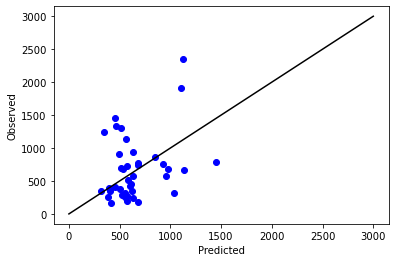

0.3350132745212335
0.9547073003803005


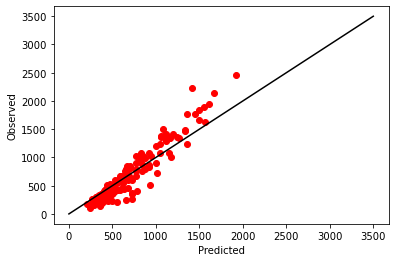

In [67]:
plt.scatter(y_pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print(np.corrcoef(yargs_test, y_pred)[0, 1])
##the individual bands were better by themselves

np.corrcoef(yargs_test, y_pred)[0, 1]

train_pred = reg_x.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print(np.corrcoef(train_pred, yargs_train)[0, 1])

In [31]:
##xgboost - seems to perform worse than random forest, at least with initial data
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## split data into X and y
xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation']] 
yargs=df1['Mean_Biomass'] 

## split data into train and test sets
size_x = 0.2
seed = 0
x_xg_train, x_xg_test, y_xg_train, y_xg_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed)

##fit model no training data
xg_reg = XGBClassifier()
xg_reg.fit(x_xg_train, y_xg_train)

##make predictions for test data
y_xg_pred = xg_reg.predict(x_xg_test)
# predictions = [round(value) for value in y_pred]

##evaluate predictions

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_xg_test, y_xg_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_xg_test, y_xg_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_xg_test, y_xg_pred)))

r_square = metrics.r2_score(y_xg_test, y_xg_pred)
print(r_square)
print(reg_x.score(x_xg_test, y_xg_test))

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Absolute Error: 556.5021020408162
Mean Squared Error: 530694.8933131346
Root Mean Squared Error: 728.488087282925
-1.4013310585491072
0.7065353013957858


In [24]:
##Comparing with standard empirical model

print(len(xargs))
print(len(yargs))

print(xargs.head())

from sklearn import linear_model
import statsmodels.api as sm

regr = linear_model.LinearRegression()
regr.fit(xargs, yargs)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
xargs = sm.add_constant(xargs) # adding a constant
 
model = sm.OLS(yargs, xargs).fit()
predictions = model.predict(xargs) 
 
print_model = model.summary()
print(print_model) ##check model assumptions

208
208
       ndvi  nd_swir2_r  nd_swir2_nir    nd_g_b    nd_r_g    wdrvi5      savi  \
0  0.297571   -0.020588     -0.316222  0.085803 -0.001439 -0.039700  0.073647   
1  0.338997    0.155266     -0.193939  0.223881 -0.073810  0.006386  0.096892   
2  0.410559    0.045918     -0.371648  0.084165 -0.007958  0.089470  0.124661   
3  0.545648    0.043219     -0.514563  0.084629  0.011024  0.259516  0.180337   
4  0.341253    0.035573     -0.309436  0.038640 -0.048362  0.008936  0.138354   

   Elevation  
0   0.956989  
1   0.956989  
2   0.956989  
3   0.956989  
4   0.956989  
Intercept: 
 9840.743546806592
Coefficients: 
 [-19461.04720164  -5913.328827     7354.71263295   -243.45093898
  -1388.67154462  22389.35239143   1721.70848888   -615.7820754 ]
                            OLS Regression Results                            
Dep. Variable:           Mean_Biomass   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.148


In [ ]:
##Major question: why is the averaged dataset random forest worse than the individual plots rf? Sample size?
##Or is zonal_stats pixel extraction not what you think it is?